In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark

# # 创建SparkSession
# spark = SparkSession.builder.appName('MusicAnalysis').getOrCreate()

# # 读取CSV文件
# df = spark.read.csv('data/image_gps_data.csv', header=True)

print(pyspark.__version__)


3.3.0


In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, BucketedRandomProjectionLSH
from pyspark.sql.functions import rand, udf
from pyspark.sql.types import IntegerType
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd


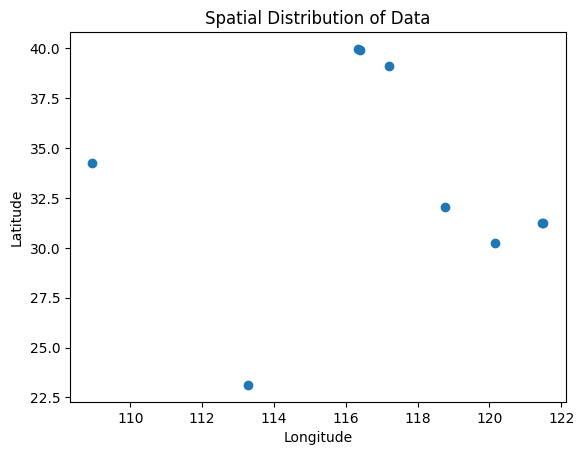

Longitude statistics:
count      9.000000
mean     117.121889
std        4.073205
min      108.948000
25%      116.354000
50%      117.210000
75%      120.161000
max      121.500000
Name: longitude, dtype: float64
Latitude statistics:
count     9.000000
mean     33.462111
std       5.543311
min      23.125000
25%      31.224000
50%      32.041000
75%      39.123000
max      39.974000
Name: latitude, dtype: float64


In [6]:




# Read the data from a CSV file
df = pd.read_csv("data/image_gps_data.csv")

# Plot the longitude and latitude values as a scatter plot
plt.scatter(df["longitude"], df["latitude"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Data")
plt.show()

# Print the statistics of the longitude and latitude values
print("Longitude statistics:")
print(df["longitude"].describe())
print("Latitude statistics:")
print(df["latitude"].describe())

In [7]:
# Create a SparkConf object and set the app name
conf = SparkConf().setAppName("DBSCAN Demo")

# Create a SparkContext object
sc = SparkContext(conf=conf)

# Create a SparkSession object
spark = SparkSession.builder.appName("DBSCAN Demo").getOrCreate()
# Read the data from a CSV file and create a DataFrame
df = spark.read.csv("data/image_gps_data.csv", header=True, inferSchema=True)

23/03/05 22:37:27 WARN Utils: Your hostname, AbeldeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.104 instead (on interface en0)
23/03/05 22:37:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/05 22:37:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:


# Select the columns that represent the spatial coordinates
cols = ["longitude", "latitude"]
df_coords = df.select(*cols)

# Convert the DataFrame to a feature vector format
vectorAssembler = VectorAssembler(inputCols=cols, outputCol="features")
df_features = vectorAssembler.transform(df_coords).select("features")

# Define the DBSCAN clustering algorithm
eps = 0.1
min_pts = 5
num_hash_tables = 5
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", numHashTables=num_hash_tables, bucketLength=eps)
model = brp.fit(df_features)
similarities = model.approxSimilarityJoin(df_features, df_features, eps, distCol="distance")
clustered = similarities.filter(f"distance <= {eps}").groupBy("datasetA").agg(F.collect_set("datasetB").alias("neighbors"))
df_final = clustered.select("neighbors").distinct()

# Show the predicted clusters
df_final.orderBy(rand()).show()


23/03/05 22:37:30 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/03/05 22:37:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/05 22:37:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+--------------------+
|           neighbors|
+--------------------+
|[{[116.354,39.974...|
|[{[118.767,32.041...|
|[{[121.473,31.23]...|
|[{[113.28,23.125]...|
|[{[120.161,30.264...|
|[{[108.948,34.263...|
|[{[117.21,39.123]...|
+--------------------+



In [15]:
# Loop through the predicted clusters
for row in df_final.collect():
    cluster = row['neighbors']
    print(f"Cluster: {cluster}")


Cluster: [Row(features=DenseVector([120.161, 30.264]), hashes=[DenseVector([-18.0]), DenseVector([-1220.0]), DenseVector([-452.0]), DenseVector([783.0]), DenseVector([-1210.0])])]
Cluster: [Row(features=DenseVector([117.21, 39.123]), hashes=[DenseVector([75.0]), DenseVector([-1230.0]), DenseVector([-363.0]), DenseVector([706.0]), DenseVector([-1183.0])])]
Cluster: [Row(features=DenseVector([108.948, 34.263]), hashes=[DenseVector([50.0]), DenseVector([-1134.0]), DenseVector([-355.0]), DenseVector([669.0]), DenseVector([-1099.0])])]
Cluster: [Row(features=DenseVector([113.28, 23.125]), hashes=[DenseVector([-69.0]), DenseVector([-1128.0]), DenseVector([-470.0]), DenseVector([770.0]), DenseVector([-1139.0])])]
Cluster: [Row(features=DenseVector([121.473, 31.23]), hashes=[DenseVector([-12.0]), DenseVector([-1236.0]), DenseVector([-452.0]), DenseVector([787.0]), DenseVector([-1223.0])]), Row(features=DenseVector([121.5, 31.224]), hashes=[DenseVector([-12.0]), DenseVector([-1236.0]), DenseVec